     ┌───┐┌──────────────┐                         ┌─┐                  
q_0: ┤ H ├┤ Rx(0.023004) ├──■─────────■────────────┤M├──────────────────
     ├───┤└┬────────────┬┘┌─┴─┐       │            └╥┘┌─┐               
q_1: ┤ H ├─┤ Rx(4.6745) ├─┤ X ├──■────┼─────────■───╫─┤M├───────────────
     ├───┤ ├────────────┤ └───┘┌─┴─┐  │         │   ║ └╥┘┌─┐            
q_2: ┤ H ├─┤ Rx(1.3128) ├──────┤ X ├──┼────■────┼───╫──╫─┤M├────────────
     ├───┤ ├────────────┤      └───┘  │  ┌─┴─┐  │   ║  ║ └╥┘┌─┐         
q_3: ┤ H ├─┤ Ry(2.2455) ├───■─────────┼──┤ X ├──┼───╫──╫──╫─┤M├─────────
     ├───┤ ├────────────┤ ┌─┴─┐       │  └───┘┌─┴─┐ ║  ║  ║ └╥┘┌─┐      
q_4: ┤ H ├─┤ Ry(2.9008) ├─┤ X ├──■────┼───────┤ X ├─╫──╫──╫──╫─┤M├──────
     ├───┤ ├────────────┤ └───┘┌─┴─┐  │       └───┘ ║  ║  ║  ║ └╥┘┌─┐   
q_5: ┤ H ├─┤ Ry(3.8135) ├──────┤ X ├──┼────■────────╫──╫──╫──╫──╫─┤M├───
     ├───┤ ├────────────┤      └───┘┌─┴─┐  │   ┌─┐  ║  ║  ║  ║  ║ └╥┘   
q_6: ┤ H ├─┤ Rz(4.7507) ├───■───────┤ X ├──┼───┤M├─

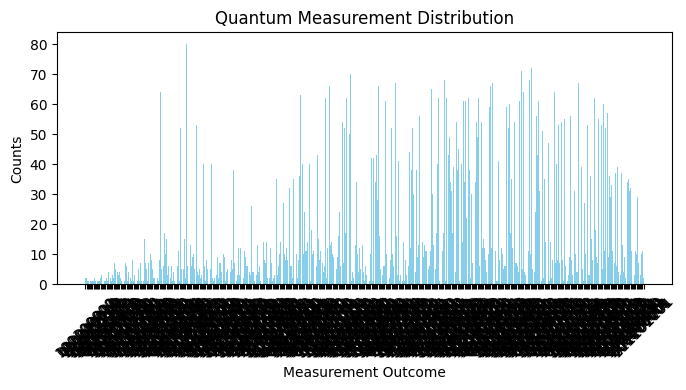

Measurement Counts: {'100100000': 2, '111000010': 2, '000010001': 1, '010000010': 1, '000110010': 1, '111010000': 1, '101011100': 1, '011001110': 1, '010100000': 2, '111000011': 1, '100000010': 1, '101111110': 1, '110011101': 1, '000111111': 2, '000011110': 3, '111101100': 1, '110110011': 1, '100111110': 1, '010010001': 2, '001111111': 1, '011001011': 4, '001011110': 2, '001110011': 1, '001001100': 3, '000010000': 2, '000100010': 7, '100110001': 5, '011100011': 4, '001001101': 3, '111001011': 4, '110011111': 2, '001010000': 1, '100010011': 4, '000101100': 1, '101001011': 7, '010110001': 6, '100001111': 1, '011011110': 4, '001011100': 2, '111011101': 1, '000000000': 8, '111100001': 1, '001010001': 3, '111100000': 1, '101101101': 1, '110011000': 5, '100111111': 1, '100001011': 7, '010110010': 1, '001111110': 1, '111111011': 15, '111101000': 7, '011111100': 5, '010000011': 1, '000000110': 7, '101101000': 10, '110100011': 8, '001100011': 5, '011001111': 2, '110111110': 2, '100000001': 9, '

In [7]:
# %% [markdown]
# # Quantum Analysis Notebook
# 
# This notebook:
# 1. Imports your existing `01-extractfeatures.py` so we can reuse the audio-analysis and
#    database functions/classes (like `QuantumMusicDB`).
# 2. Defines new quantum-computing utilities (`_compute_quantum_features_from_analysis`,
#    `quantum_pipeline_complex`) that operate on the existing `analysis_data`.
# 3. Provides a `run_and_store_quantum_analysis` function that:
#    - Fetches the audio analysis record by ID from your PostgreSQL DB
#    - Computes a quantum circuit on the data
#    - Stores the results back into the JSON (`analysis_data`) of that record.

# %% [markdown]
# ### 0. Notebook Setup: Auto-Reload and Imports


import logging
import numpy as np
import matplotlib.pyplot as plt
import pprint

# We'll assume 01-extractfeatures.py is in the same directory or along your PYTHONPATH
import sys
sys.path.append('.')  # or adjust path as needed
import importlib

# Attempt to import your "01-extractfeatures.py" module:
ef = importlib.import_module("01-extractfeatures")

# From Qiskit, import what we need for the quantum circuit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# You can add any other imports here if needed:
# e.g., from qiskit.visualization import plot_histogram


# Configure logging to show only INFO-level messages.
logging.basicConfig(level=logging.CRITICAL,
                    format='[%(levelname)s] %(asctime)s - %(message)s',
                    datefmt='%H:%M:%S')
# Suppress Qiskit transpiler INFO messages
logging.getLogger('qiskit.transpiler').setLevel(logging.WARNING)
logging.getLogger('qiskit.providers.aer').setLevel(logging.WARNING)
logging.getLogger('qiskit').setLevel(logging.WARNING)


# --- Helper function to encode a detected raga ---
def encode_raga(raga):
    """
    Encodes a raga string into a numerical value.
    A simple encoding: if raga is a string, compute the sum of the Unicode code points 
    modulo 100 and normalize to [0, 1]. Replace this with a domain-specific encoding as needed.
    """
    if raga is None:
        return 0.0
    if isinstance(raga, str):
        return (sum(ord(c) for c in raga) % 100) / 100.0
    try:
        return float(raga)
    except Exception:
        return 0.0


def scale_features_individually(features, loIr_bounds, upper_bounds):
    """
    Scales each feature individually from its own [loIr, upper] range to [0, 2*pi].
    - features: list of raw feature values.
    - loIr_bounds: list of loIr bounds for each feature.
    - upper_bounds: list of upper bounds for each feature.
    Returns a list of scaled angles.
    """
    scaled = []
    for f, l, u in zip(features, loIr_bounds, upper_bounds):
        spread = u - l if u != l else 1
        scaled_angle = ((f - l) / spread) * 2 * np.pi
        scaled.append(scaled_angle)
    return scaled


def nonlinear_scale_features(features):
    """
    Scales a list of features into rotation angles in [0, 2π] using an arctan transformation.
    The transformation centers the features around their median and compresses them based on
    the median absolute deviation (MAD).
    
    The formula for each feature f is:
       angle = [arctan(scaling_factor * (f - median)) + π/2] * 2
    where scaling_factor = 1 / MAD (with a fallback if MAD is zero).
    """
    features = np.asarray(features, dtype=float)
    median_val = np.median(features)
    mad = np.median(np.abs(features - median_val))
    if mad == 0:
        mad = np.std(features) if np.std(features) > 0 else 1.0
    scaling_factor = 1.0 / mad
    
    scaled = []
    for f in features:
        angle = (np.arctan(scaling_factor * (f - median_val)) + (np.pi / 2)) * 2
        scaled.append(angle)
    return scaled


# --- Function to compute quantum features from analysis_dict ---
# --- Carefully crafted based on musical understanding and perceptual relevance ---
import numpy as np

# 1. Average Pitch Deviation (sigmoid/logistic scaling)
def scale_pitch_dev(pitch_dev_cents):
    d0 = 430.33  # updated median pitch deviation
    k = 50       # musical perceptual scaling
    angle = 2 * np.pi / (1 + np.exp(-(pitch_dev_cents - d0) / k))
    return float(angle)

# 2. Average Jitter (logistic scaling)
def scale_jitter(jitter):
    j0 = 0.00554  # updated median jitter
    a = 300       # steepness factor
    angle = 2 * np.pi / (1 + np.exp(-a * (jitter - j0)))
    return float(angle)

# 3. Standard Deviation of Tempo (relative tempo stability, tanh scaling)
def scale_tempo_std(tempo_std_bpm, tempo_mean_bpm):
    tempo_rel = tempo_std_bpm / tempo_mean_bpm
    r = 0.025  # 2.5% variability perceptual threshold
    angle = 2 * np.pi * np.tanh(tempo_rel / r)
    return float(angle)

# 4. Average Shimmer (logistic scaling)
def scale_shimmer(shimmer):
    s0 = 0.10758  # updated median shimmer
    b = 30        # steepness factor
    angle = 2 * np.pi / (1 + np.exp(-b * (shimmer - s0)))
    return float(angle)

# 5. Average LUFS (linear scaling)
def scale_lufs(lufs):
    lufs_min, lufs_max = -35, -4  # updated based on new LUFS range
    angle = 2 * np.pi * (lufs - lufs_min) / (lufs_max - lufs_min)
    angle = np.clip(angle, 0, 2 * np.pi)
    return float(angle)

# 6. Standard Deviation of LUFS (linear scaling)
def scale_lufs_std(lufs_std):
    std_max = 10  # consistent maximum dynamic variability
    angle = 2 * np.pi * lufs_std / std_max
    angle = np.clip(angle, 0, 2 * np.pi)
    return float(angle)

# 7. MFCC Standard Deviation (log scaling)
def scale_mfcc_std(mfcc_std):
    mfcc_max = 30  # stable upper-bound for MFCC variability
    angle = 2 * np.pi * np.log1p(mfcc_std) / np.log1p(mfcc_max)
    angle = np.clip(angle, 0, 2 * np.pi)
    return float(angle)

# 8. Zero Crossing Rate (linear capped scaling)
def scale_zcr(zcr):
    zcr_cap = 0.2  # consistent fixed bound
    angle = 2 * np.pi * min(zcr, zcr_cap) / zcr_cap
    return float(angle)

# 9. Harmonics-to-Noise Ratio (HNR in dB, inverse linear scaling)
def scale_hnr(hnr_db):
    hnr_min, hnr_max = 0, 20  # standard HNR range (0–20 dB)
    angle = 2 * np.pi * (hnr_max - np.clip(hnr_db, hnr_min, hnr_max)) / (hnr_max - hnr_min)
    return float(angle)

# Convenience function to scale all features at once:
def scale_all_features(features):
    """
    Takes a feature vector (matching your quantum circuit order) and returns scaled angles:
    [avg_pitch_dev, avg_jitter, std_tempo_dev, avg_shimmer, avg_lufs, std_lufs, 
     mfcc_std, avg_zcr, avg_hnr]
    """
    avg_pitch_dev, avg_jitter, std_tempo_dev, avg_shimmer, avg_lufs, std_lufs, mfcc_std, avg_zcr, avg_hnr = features

    angles = [
        scale_pitch_dev(avg_pitch_dev),                      # Rx
        scale_jitter(avg_jitter),                            # Rx
        scale_tempo_std(std_tempo_dev, 139.5645),            # Rx, using mean tempo provided
        scale_shimmer(avg_shimmer),                          # Ry
        scale_lufs(avg_lufs),                                # Ry
        scale_lufs_std(std_lufs),                            # Ry
        scale_mfcc_std(mfcc_std),                            # Rz
        scale_zcr(avg_zcr),                                  # Rz
        scale_hnr(avg_hnr)                                   # Rz
    ]
    return angles


def _compute_quantum_features_from_analysis(analysis_dict):
    import numpy as np

    # Extract main summary & time_matrices
    summary = analysis_dict.get("summary", {})
    time_matrices = analysis_dict.get("time_matrices", {})
    tmatrix_small = time_matrices.get("time_matrix_small", [])

    # 1) Summaries for pitch dev, lufs, tone_to_noise, etc.
    pitch_dev = summary.get("pitch_deviation", {})
    avg_pitch_dev = pitch_dev.get("mean", 0.0)

    dyn_lufs = summary.get("dynamics", {}).get("lufs", {})
    avg_lufs = dyn_lufs.get("mean", 0.0)
    std_lufs = dyn_lufs.get("std", 0.0)

    hnr_dict = summary.get("harmony_to_noise_ratio", {})
    avg_hnr = hnr_dict.get("mean", 0.0)

    # We'll also grab the 40 MFCC std from spectral_summary (already aggregated)
    spectral_summary = summary.get("spectral_summary", {})
    mfcc_std_list = spectral_summary.get("mfcc_std", [])
    overall_mfcc_std = float(np.mean(mfcc_std_list)) if len(mfcc_std_list) > 0 else 0.0

    # 2) Single-pass iteration over `time_matrix_small` for jitter, shimmer, tempo_bpm, zcr, etc.
    jitter_vals    = []
    shimmer_vals   = []
    tempo_bpm_vals = []
    zcr_vals       = []

    # We only collect numeric > 0 if that’s your convention
    for row in tmatrix_small:
        # Jitter
        j = row.get("jitter", 0.0)
        if isinstance(j, (int, float)) and j > 0.0:
            jitter_vals.append(j)

        # Shimmer
        s = row.get("shimmer", 0.0)
        if isinstance(s, (int, float)) and s > 0.0:
            shimmer_vals.append(s)

        # Tempo
        tbpm = row.get("tempo_bpm", 0.0)
        if isinstance(tbpm, (int, float)) and tbpm > 0.0:
            tempo_bpm_vals.append(tbpm)

        # ZCR
        z = row.get("zcr", 0.0)
        if isinstance(z, (int, float)) and z > 0.0:
            zcr_vals.append(z)

    # Now compute your aggregated stats
    avg_jitter      = float(np.mean(jitter_vals))      if jitter_vals      else 0.0
    avg_shimmer     = float(np.mean(shimmer_vals))     if shimmer_vals     else 0.0
    std_tempo_dev   = float(np.std(tempo_bpm_vals))    if tempo_bpm_vals   else 0.0
    avg_zcr         = float(np.mean(zcr_vals))         if zcr_vals         else 0.0

    # 3) Build final 9-element feature vector (matching your 9 qubits).
    # Reusing your existing order: 
    #   (0) avg_pitch_dev
    #   (1) avg_jitter
    #   (2) std_tempo_dev
    #   (3) avg_shimmer
    #   (4) avg_lufs
    #   (5) std_lufs
    #   (6) overall_mfcc_std
    #   (7) avg_zcr
    #   (8) avg_tnr

    feature_vector = [
        avg_pitch_dev,      # Qubit 0 -> Rx
        avg_jitter,         # Qubit 1 -> Rx
        std_tempo_dev,      # Qubit 2 -> Rx
        avg_shimmer,        # Qubit 3 -> Ry
        avg_lufs,           # Qubit 4 -> Ry
        std_lufs,           # Qubit 5 -> Ry
        overall_mfcc_std,   # Qubit 6 -> Rz
        avg_zcr,            # Qubit 7 -> Rz
        avg_hnr             # Qubit 8 -> Rz
    ]


    return feature_vector


def quantum_pipeline_complex(feature_vector, shots):
    """
    Quantum circuit pipeline for musical feature analysis.
    Input: feature_vector - PRE-SCALED angles in the correct order:
      [average_pitch_deviation, average_jitter, std_tempo_deviation,
       average_shimmer, average_lufs_energy, std_lufs_energy,
       std_mfcc, zero_crossing_rate, average_tone_to_noise_ratio]

    Returns: scaled_features, counts
    """

    from qiskit import QuantumCircuit, transpile
    from qiskit_aer import AerSimulator
    from qiskit.visualization import plot_histogram


    scaled_angles = scale_all_features(feature_vector)
    num_qubits = len(scaled_angles)
    qc = QuantumCircuit(num_qubits, num_qubits)

    # Step 1: Hadamard layer for initial superposition
    qc.h(range(num_qubits))

    # Step 2: Feature-based rotations
    # Rx (Pitch/Tempo): qubits 0,1,2
    qc.rx(scaled_angles[0], 0)  # avg pitch deviation
    qc.rx(scaled_angles[1], 1)  # avg jitter
    qc.rx(scaled_angles[2], 2)  # std tempo deviation

    # Ry (Dynamics/Energy): qubits 3,4,5
    qc.ry(scaled_angles[3], 3)  # avg shimmer
    qc.ry(scaled_angles[4], 4)  # avg LUFS energy
    qc.ry(scaled_angles[5], 5)  # std LUFS energy (dynamic motion)

    # Rz (Timbre/ZCR/Tonal Clarity): qubits 6,7,8
    qc.rz(scaled_angles[6], 6)  # std MFCC (timbre consistency)
    qc.rz(scaled_angles[7], 7)  # zero-crossing rate
    qc.rz(scaled_angles[8], 8)  # avg tone-to-noise ratio

    # Step 3: Intra-group entanglement
    # Rx group (pitch/tempo stability)
    qc.cx(0, 1)
    qc.cx(1, 2)

    # Ry group (energy/dynamics)
    qc.cx(3, 4)
    qc.cx(4, 5)

    # Rz group (timbre/clarity)
    qc.cx(6, 7)
    qc.cx(7, 8)

    # Step 4: Cross-group entanglement (Inter-group Coupling)
    qc.cx(2, 3)  # tempo stability ↔ shimmer (expressivity)
    qc.cx(1, 4)  # jitter ↔ avg LUFS energy
    qc.cx(0, 6)  # pitch stability ↔ timbre consistency (stylistic nuance)
    qc.cx(5, 7)  # dynamic motion ↔ zero-crossing (rhythmic clarity)

    # Step 5: Measurement
    qc.measure(range(num_qubits), range(num_qubits))

    # Optional (recommended): circuit visualization for debugging
    circuit_diagram = qc.draw(output='text')
    print(circuit_diagram)

    # Step 6: Execute on Aer simulator
    simulator = AerSimulator()
    compiled_qc = transpile(qc, simulator)
    result = simulator.run(compiled_qc, shots=shots).result()
    counts = result.get_counts()

    # Your existing function returns scaled features AND counts:
    return scaled_angles, counts, str(circuit_diagram)


def plot_quantum_counts(counts):
    """
    Plots the measurement distribution.
    """
    outcomes = list(counts.keys())
    frequencies = list(counts.values())
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.bar(outcomes, frequencies, color='skyblue')
    ax.set_xlabel("Measurement Outcome")
    ax.set_ylabel("Counts")
    ax.set_title("Quantum Measurement Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# 1. Retrieves a record by ID (via your `QuantumMusicDB` instance).
# 2. Extracts (or re-extracts) the quantum feature vector from the `analysis_data`.
# 3. Runs the quantum circuit (`quantum_pipeline_complex`).
# 4. Stores the new quantum results in `analysis_data["quantum_analysis"]`.
# 5. Updates the same record in the DB with the new JSON.

def run_and_store_quantum_analysis(db, record_id, shots=1024):
    """
    Fetches a single record from audio_analysis (by record_id),
    recomputes quantum features & circuit results,
    and updates the record's analysis_data with the new quantum_analysis.

    :param db: QuantumMusicDB instance (from 01-extractfeatures)
    :param record_id: primary key in the audio_analysis table
    :param shots: number of shots for the Qiskit simulator
    :return: Updated analysis_data or None if not found
    """
    row = db.fetch_analysis(record_id)
    if not row:
        logging.error(f"Record ID {record_id} not found in DB.")
        return None

    # row format: (id, file_name, sample_rate, analysis_data)
    analysis_data = row[3]  # analysis_data is JSONB

    if "quantum_analysis" in analysis_data:
        logging.info(f"Clearing existing quantum_analysis from record {record_id}")
        del analysis_data["quantum_analysis"]


    # 1) Build the feature vector from the existing analysis_data
    feature_vector = _compute_quantum_features_from_analysis(analysis_data)

    # 2) Run the quantum pipeline
    scaled_features, measurement_counts, circuit_diagram = quantum_pipeline_complex(feature_vector, shots=shots)
    plot_quantum_counts(measurement_counts)
    print("Measurement Counts:", measurement_counts)
    print("Scaled Features:", scaled_features)

    # 3) Store results in analysis_data
    # Overwrite or create a top-level "quantum_analysis" key
    analysis_data["quantum_analysis"] = {
        "feature_vector": feature_vector,
        "scaled_angles": scaled_features,
        "measurement_counts": dict(measurement_counts),
        "circuit_diagram": circuit_diagram
    }

    # 4) Update DB with the new analysis_data
    from psycopg2.extras import Json
    with db.conn.cursor() as cur:
        update_query = """UPDATE audio_analysis SET analysis_data = %s WHERE id = %s"""
        cur.execute(update_query, (Json(analysis_data), record_id))
        db.conn.commit()

    #logging.info(f"Quantum analysis updated for record ID {record_id}")
    return analysis_data

# 
# Below is an example of how to use these functions. 
# Adjust your database credentials as needed, then call `run_and_store_quantum_analysis` on a record ID.

# %%
if __name__ == "__main__":
    # Example usage:
    #logging.basicConfig(level=logging.CRITICAL)

    # 1) Create or reuse a QuantumMusicDB instance (assuming same credentials as in your 01-extractfeatures.py)
    db = ef.QuantumMusicDB(
        db_name=ef.DB_NAME,
        host=ef.DB_HOST,
        user=ef.DB_USER,
        password=ef.DB_PASSWORD
    )

    # # 2) Choose a record ID to run quantum analysis on
    # TEST_RECORD_ID = 1908  

    # # 3) Run the analysis
    # updated_data = run_and_store_quantum_analysis(db, TEST_RECORD_ID, shots=8192)
    # if updated_data:
    #     logging.info("Quantum analysis completed and stored:")
    #     logging.info(updated_data["quantum_analysis"])

# Example: process multiple record IDs in a single pass
# Option A: Hardcode a list
# record_ids = [1908, 1909, 1910]

# Option B: Fetch from DB (example):
with db.conn.cursor() as cur:
    cur.execute("SELECT id FROM audio_analysis WHERE id = 3797")
    rows = cur.fetchall()
record_ids = [r[0] for r in rows]

for rec_id in record_ids:
    updated_data = run_and_store_quantum_analysis(db, rec_id, shots=8192)
    if updated_data:
        logging.info(f"Quantum analysis completed for record ID {rec_id}")
        logging.info(updated_data["quantum_analysis"])

# 4) (Optional) Close DB connection
print("All Analysis Complete, last record was ", rec_id)
db.close()